In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank
from scipy.sparse import csr_matrix

In [2]:
# updated function -- verified 12/27/2023

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

# Create Graph using Bipartite Projection on Arxiv Dataset

In [119]:
data = r'data\arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Kiarash Sedghighadikolaei,A Comprehensive Survey of Threshold Digital Si...
1,Attila Altay Yavuz,A Comprehensive Survey of Threshold Digital Si...
2,Alenka {Č}opi{č},Phosphatidylserine transport in cell life and ...
3,Thibaud Dieudonné,Phosphatidylserine transport in cell life and ...
4,Guillaume Lenoir,Phosphatidylserine transport in cell life and ...


In [120]:
len(set(df['title']))

19989

In [121]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [122]:
#print(nx.info(G)) # deprecated

print(G)

Graph with 48753 nodes and 273061 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

In this notebook, I am experimenting with a python library for interactive visualization. 

## Community Detection

In [123]:
#! pip install python-louvain --user

In [124]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [125]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

community_df['community'].value_counts()[0:20]

community
10653    242
1770     193
957      182
9583     163
3938     122
4788     109
10990    108
7718      94
10344     88
5149      86
4159      80
5323      78
8789      74
3737      68
3826      67
9328      67
201       65
590       59
4460      55
10993     54
Name: count, dtype: int64

In [126]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,10653,242
1,1770,193
2,957,182
3,9583,163
4,3938,122


In [127]:
community_size_df.shape

(421, 2)

## Capture Community Context

In [128]:
community_df.head()

,node,community
0,Alenka {Č}opi{č},0
1,Thibaud Dieudonné,0
2,Guillaume Lenoir,0
3,Michele Ambrosino,5
4,Manar Mahmalji,5


In [129]:
community_size_df.head(1)

,community,node_count
0,10653,242


In [130]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [131]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        communities[community]['node_count'] = len(G_sub.nodes)
        
    return communities

In [132]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [133]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density', 'node_count']

community_context_df.head()

,community,G,density,node_count
0,10653,"(C. Capelli, T. O'Donnell, H. Z. Huang, G. Kep...",0.53064,242
1,1770,"(A. D. Ferella, G. Marissens, C. A. Ur, W. Man...",0.585816,193
2,957,"(L. V'ala, V. R. Klavdiienko, I. A. Vanyushin,...",0.512476,182
3,9583,"(C. Chambers, L. J. Wen, M. G. Marino, Q. Xia,...",0.78361,163
4,3938,"(R. den Hartog, P. Chen, N. Elias, R. Waters, ...",0.952175,122


<Axes: ylabel='Frequency'>

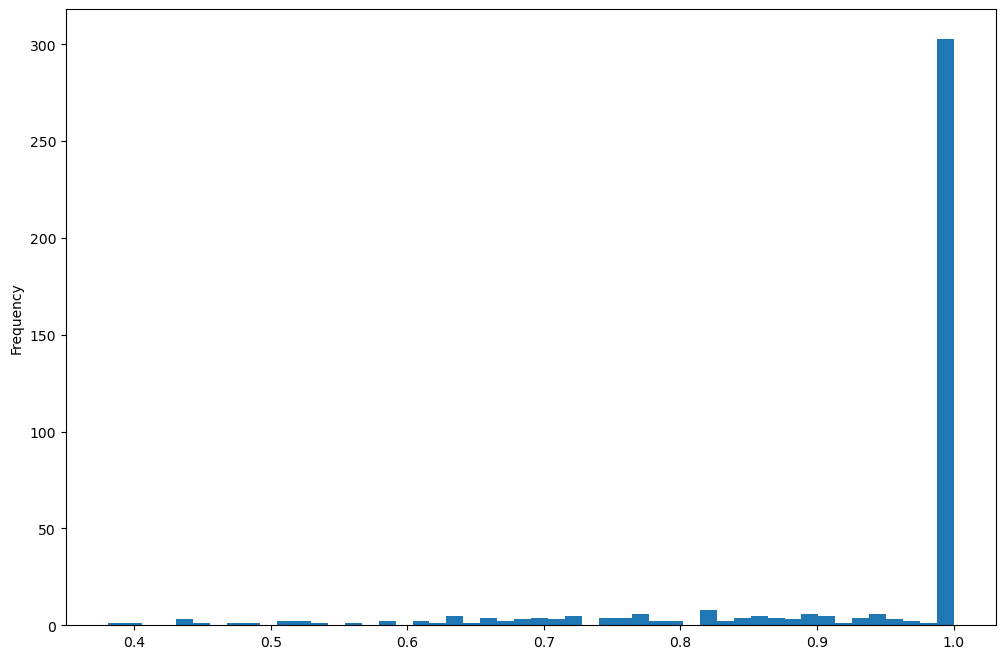

In [134]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

In [135]:
def show_author_papers(df, G):
    
    G = G.copy()
    
    check_nodes = G.nodes

    return sorted(df[df['authors'].isin(check_nodes)]['title'].unique())

In [136]:
def fetch_communities(community_context_df, min_density, max_density, max_nodes=None, n_communities=10):
    
    if max_nodes==None:
        community_context_df['node_count'].sum()
    
    community_context_df = community_context_df.copy()

    mask = (community_context_df['density']>min_density) \
        & (community_context_df['density']<max_density)  \
        & (community_context_df['node_count']<max_nodes)
    
    community_context_df = community_context_df[mask].copy()
    #community_context_df = community_context_df.sample(n_communities) # grabbing ten to see the ranges

    community_context_df.sort_values('density', inplace=True)
    communities = community_context_df['community'].values[0:n_communities]
    
    return communities

In [137]:
def draw_community(G_check):

    print('Density: {}'.format(nx.density(G_check)))
    print('Node Count: {}'.format(len(G_check.nodes)))
    return draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

In [142]:
min_density = 0.4
max_density = 0.7
max_nodes = 500

# .1 to .3 has more papers and more variation
# .3 to .6 is very cool
# .6 to .8 is cool to describe smaller more densely connected groups

# i did several iterations to find titles; sparse communities seem to have more and more interesting papers (opinion)

communities = fetch_communities(community_context_df, min_density=min_density, max_density=max_density, max_nodes=max_nodes, n_communities=20)
communities

array([ 6686,  6760,  9898,  6745,  3373,  7782,  3993,   957,  1976,
         241,  5579, 10653,  5144,  1770,  2920,  1159,  1594,  8286,
       10133,  4303], dtype=int64)

Density: 0.44166666666666665
Node Count: 16


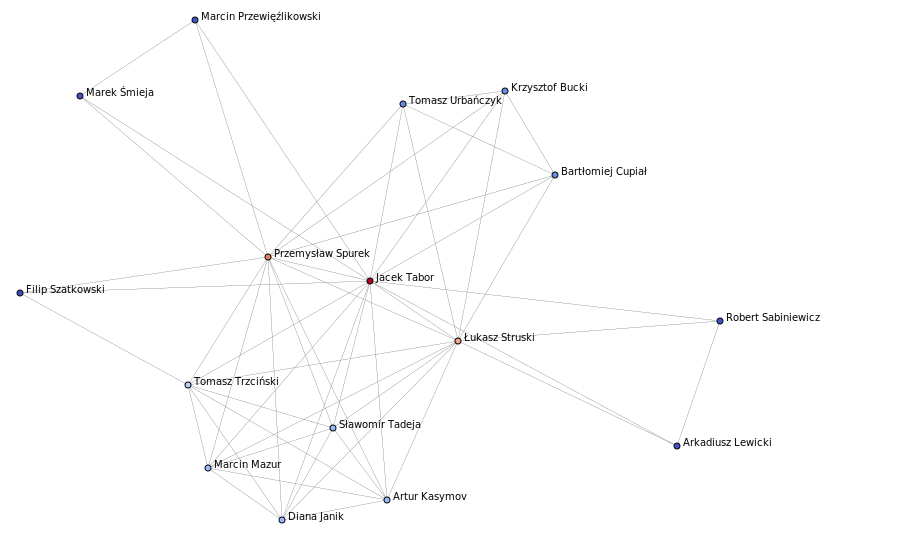

In [150]:
G_check = community_context_dict[communities[3]]['G']
draw_community(G_check)

In [151]:
show_author_papers(df, G_check)

#Efficient Top-k Ego-Betweenness Search
#Fast Algorithms for Intimate-Core Group Search in Weighted Graphs
#Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks
#Mining Bursting Communities in Temporal Graphs

['End-to-end Sinkhorn Autoencoder with Noise Generator',
 'Extreme Entropy Machines: Robust information theoretic classification',
 'Generalized Continual Category Discovery',
 'HyperPocket: Generative Point Cloud Completion',
 'Hypernetworks build Implicit Neural Representations of Sounds',
 'MeVGAN: GAN-based Plugin Model for Video Generation with Applications in Colonoscopy',
 'Multiband VAE: Latent Space Alignment for Knowledge Consolidation in Continual Learning',
 'Neural Comic Style Transfer: Case Study',
 'ProMIL: Probabilistic Multiple Instance Learning for Medical Imaging',
 'ProPaLL: Probabilistic Partial Label Learning',
 'RegFlow: Probabilistic Flow-based Regression for Future Prediction']

# Interactive Exploration

I'll use G_check graph with libraries for interactive exploration.

So far, not worth the effort of getting it to open in the notebook directly. I get this error. Will open in a tab instead.

Error:
'charmap' codec can't encode characters in position 263607-263621: character maps to <undefined>

In [152]:
#!pip install pyvis --upgrade --user

In [153]:
from pyvis.network import Network

In [155]:
# point to the full path or else jupyter might fail to open it even outside of jupyter; edge will try and fail
pyvis_file = r'C:/Users/itsgo/PythonCode/100daysofnetworks/pyvis/arxiv_community.html' 

# flip between communities to explore
G_check = community_context_dict[communities[3]]['G']

net = Network(height='900px') # tweak for your browser; can also do width
net.from_nx(G_check)
# net.show_buttons() # gives you additional buttons at the bottom
net.show(pyvis_file, notebook=False) # can't get notebook=True to work yet...

C:/Users/itsgo/PythonCode/100daysofnetworks/pyvis/arxiv_community.html


In [112]:
[print(n) for n in G_check.nodes]

Sergey V. Buldyrev
Daniele Ietri
Xiaoming Xu
Cecilia Lagorio
Lazaros K. Gallos
Nina H. Fefferman
Zhenhua Wu
Vittoria Colizza
Maksim Kitsak
Qian Li
Massimo Riccaboni
Shlomo Havlin
Yang Dai
Louis Shekhtman
Xuqing Huang
Paul A. Trunfio
Roni Parshani
Gerald Paul
Yuanhui Ma
Lucas D. Valdez
H. Eugene Stanley
Xingshu Chen
Jia Shao
Lidia A. Braunstein
Cristian E. La Rocca
Reuven Cohen
Celine Rozenblat
Mark Dickison
Cesar Ducruet


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]